<a href="https://www.kaggle.com/code/mldaniella/predicting-apartment-prices-in-seoul?scriptVersionId=97304817" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>


# Predicting apartment prices in Seoul

Mi Lim Kim - Jun 2022


# Default setting

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/seoul-apt-prices-20062012/APT_price_seoul_2006_2012.csv


# Outline

We will follow those steps to predict house prices of the apartments in Seoul.


1. Program Setting and Data Loading
2. Preprocessing features 
 > * numeric & categorical variables (imputation & encoding)
 > * adding new features & regularization
3. Implementation of models and algorithms
4. Fitting, prediction and evaluation

# Questions

The questions we want to answer by doing this analysis are as follows.

1. Which machine is the best model to predict apartment prices of Seoul? 
2. What is the set of characteristics (features) related to the apartments that should be considered to predict house prices effectively?


# Packages used

First, we load some packages by executing the lines below to make an environment for this analysis.

In [2]:
# graphs
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import warnings

# stats
from scipy.stats import skew
from scipy import stats
from scipy.stats.stats import pearsonr
from scipy.stats import norm
from collections import Counter

# models
from xgboost import XGBRegressor
import lightgbm as lgb
from sklearn import svm
from sklearn.svm import SVC, SVR
from sklearn.linear_model import LinearRegression,LassoCV, Ridge, LassoLarsCV,ElasticNetCV
from sklearn.model_selection import GridSearchCV, cross_val_score, learning_curve, train_test_split
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn import neighbors
from sklearn.neural_network import MLPClassifier, MLPRegressor

from sklearn.preprocessing import StandardScaler, Normalizer, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.metrics import confusion_matrix # creates a confusion matrix
from sklearn.metrics import plot_confusion_matrix # draws a confusion matrix
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.metrics import precision_score, accuracy_score

# pipeline
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

warnings.filterwarnings('ignore')
sns.set(style='white', context='notebook', palette='deep')

%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notebook
%matplotlib inline



# Data loading



We use apartment sale prices of Seoul registered in 2012.

The features of apartments can be categorized with severeal levels.
- Individual apartment level feature (e.g. size, floor)
- APT complex level feature (e.g. construction year, number of apartments per complex)
- District (borough) level feature (e.g. school quality)




In [3]:
# Loading the data set
apt_price=pd.read_csv("../input/seoul-apt-prices-20062012/APT_price_seoul_2006_2012.csv")

#change the unit of price from Won to Dollar
apt_price["price"] = apt_price["price"]*10


# Features used

* We select the features ('features_selected') and the target variable ('y').

* Target variable **'y'**: apartment transaction price in 2012.
* Variables **'features_slected'** and explanations on those variables are as follows:

> 1. `BuildId`: apartment complex ID. It indentifies that the apartment belongs to which APT complex.
> 2. `District`: name of district (borough) where the APT (or APT complex) is located.
> 3. `maxBuild`: the number of apt building in the APT complex. In South Korea, the apartment complex with many households is more appreciated since when new amenities are introduced for the complex, economic burden for each household is smaller then it facilitates to construct amenities for the complex.
> 4. `Built_year`: the construction year of the APT complex.
> 5. `Hhld`: the number of household living in the APT complex.
> 6. `yearmon`: the year and month when the apartment was sold.
> 7. `Floor`: floor of the APT
> 8. `Size`: size of the APT
> 9. `dong`: name of subdistrict where the APT is located.
> 10. `schoolDistHS`: name of the school district where the APT is located
> 11. `new..prop..snu23`: measure of school quality of the school district
> 12. `Age_complex`: age of the complex where the APT belongs.

* We can see that some features represent same (or similar) characteristics fo the apartments (e.g. 'Age_complex' and 'Built_year'). We deal whith this problem in a later part of this analysis.


# Preprocessing of features

* ## Making sets of data for training and validation of models

In [4]:
# Set of features to be used 
features_selected = ['District', 'maxBuild', 'Hhld', 'Floor', 'Size', 'schoolDistHs', 'new..prop..snu23','Age_complex', 'yearmon', 'BuildId']

def select_dat_specific_year(yr, fraction=None):
    # Select data of the APTs that were sold in yr
    if fraction is None:
        apt_price12 = apt_price[apt_price['year'] == yr]
    else:
        apt_price12 = apt_price[apt_price['year'] == yr]
        apt_price12 = apt_price12.sample(frac=fraction)

    # Remove rows with missing target, separate target from predictors
    X_full = apt_price12.dropna(axis=0, subset=['price'])

    X = X_full[features_selected]
    y = X_full.price
    
    return X, y


# Making train/validation data set

X, y = select_dat_specific_year(yr=2012)

# Break off validation set from training data
X_train_full, X_valid_full, y_train, y_valid = train_test_split(X, y, 
                                                                train_size=0.8, test_size=0.2,
                                                                random_state=0)


# Select categorical columns with dtype=object that will be encoded in a later part
categorical_cols0 = [cname for cname in X_train_full.columns if 
                    X_train_full[cname].dtype == "object"]
categorical_cols = list(set(categorical_cols0) - set(['yearmon', 'BuildId']))

# Select numerical columns that will be imputed in a later part
numerical_cols = [cname for cname in X_train_full.columns if 
                X_train_full[cname].dtype in ['int64', 'float64']]


# Keep selected columns only
my_cols = categorical_cols0 + numerical_cols

X_train = X_train_full[my_cols].copy()
X_valid = X_valid_full[my_cols].copy()

# Making test data set (we will use 2011 data as test data)

X_test_full, y_test_full = select_dat_specific_year(yr = 2011, fraction=0.1)
X_test = X_test_full[my_cols].copy()
y_test = y_test_full.copy()

* ## Imputation of numeric variables

We impute missing values with the mean value along each column of numerical variables. 


In [5]:
# Verify the number of missing values for each numeric variable
missing_val_count_by_column = (X_train.isnull().sum())
print(missing_val_count_by_column[missing_val_count_by_column > 0])

# Fill in the lines below: imputation

# Imputation for numerical_cols
my_imputer = SimpleImputer(strategy="mean") 
imputed_X_train = pd.DataFrame(my_imputer.fit_transform(X_train[numerical_cols]))
imputed_X_valid = pd.DataFrame(my_imputer.transform(X_valid[numerical_cols]))
imputed_X_test = pd.DataFrame(my_imputer.transform(X_test[numerical_cols]))

# Fill in the lines below: imputation removed column names; put them back
imputed_X_train.columns = numerical_cols
imputed_X_valid.columns = numerical_cols
imputed_X_test.columns = numerical_cols

# Put index
imputed_X_train.index=X_train.index
imputed_X_valid.index=X_valid.index
imputed_X_test.index=X_test.index


maxBuild       5
Hhld           5
Age_complex    5
dtype: int64


* ## Encoding categorical variables

* we encode the categorical variables using the one-hot encoding way.
* then, we combine encoded categorical variables with numeric variables.


In [6]:
# condition
OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# do one-hot encode the categorical_cols
OH_X_train0 = pd.DataFrame(OH_encoder.fit_transform(X_train[categorical_cols])) 
OH_X_valid0 = pd.DataFrame(OH_encoder.transform(X_valid[categorical_cols]))
OH_X_test0 = pd.DataFrame(OH_encoder.transform(X_test[categorical_cols]))

# put index 
OH_X_train0.index = X_train.index
OH_X_valid0.index = X_valid.index
OH_X_test0.index = X_test.index

# combine encoded categorical_cols with numeric variables + rest of variables ('BuildId', 'yearmon')
OH_X_train = pd.concat([imputed_X_train, OH_X_train0, X_train[['BuildId', 'yearmon']]], axis=1)
OH_X_valid = pd.concat([imputed_X_valid, OH_X_valid0, X_valid[['BuildId', 'yearmon']]], axis=1)
OH_X_test = pd.concat([imputed_X_test, OH_X_test0, X_test[['BuildId', 'yearmon']]], axis=1)

In [7]:
categorical_cols


['schoolDistHs']

# Adding more features and/or selecting the optimal set of features

* We can add more features by transforming the existing features and/or limit the number of features to be used for training machines to improve the performances (reducing over-fitting problem).
* [Reference 1 for feature generation](https://www.kaggle.com/mldaniella/exercise-feature-generation)
* [Reference 2 for feature selection](https://www.kaggle.com/mldaniella/exercise-feature-selection), [and another reference](https://blog.datadive.net/selecting-good-features-part-ii-linear-models-and-regularization/)

In [8]:
# Add the second power of size to capture the nonlinearity of the effect of size on house prices.

def second_power(series):
    # series is changed to numpy array.
    
    tmp=np.array(series)
    tmp2=tmp**2
    
    # the new series is changed to panda series.
    
    tmp3=pd.Series(tmp2)
    tmp3.index=series.index
    
    return tmp3

# Apply the fct defined above.

OH_X_train['Size2']=second_power(OH_X_train['Size'])
OH_X_valid['Size2']=second_power(OH_X_valid['Size'])
OH_X_test['Size2']=second_power(OH_X_test['Size'])


# Verify if there is missing values in the new series

OH_X_train['Size2'].isnull().sum()
OH_X_valid['Size2'].isnull().sum()
OH_X_test['Size2'].isnull().sum()

0

In [9]:
# Add the number of APT sales of the month happened by APT complex

def count_past_sales(series):
    
    # time_stamp
    
    series2 = pd.to_datetime(series)
    sale_time = pd.Series(series2.index, index=series2, name='count_sales_this_month').sort_index() # exchange the positions of index and values
    count_1month= sale_time.rolling('30D', min_periods=1).count()
    count_1month_2=count_1month.groupby(count_1month.index.month).transform('last')
    return count_1month_2

aa=OH_X_train.groupby('BuildId')['yearmon'].apply(count_past_sales)
bb=OH_X_valid.groupby('BuildId')['yearmon'].apply(count_past_sales)
cc=OH_X_test.groupby('BuildId')['yearmon'].apply(count_past_sales)

# put index
aa.index=OH_X_train.sort_values(by=['BuildId','yearmon']).index
bb.index=OH_X_valid.sort_values(by=['BuildId','yearmon']).index
cc.index=OH_X_test.sort_values(by=['BuildId','yearmon']).index

OH_X_train['num_sales_same_month_by_complex']=aa
OH_X_valid['num_sales_same_month_by_complex']=bb
OH_X_test['num_sales_same_month_by_complex']=cc

# drop 'BuildId' and 'yearmon' columns
OH_X_train.drop(['BuildId', 'yearmon'], axis=1, inplace=True)
OH_X_valid.drop(['BuildId', 'yearmon'], axis=1, inplace=True)
OH_X_test.drop(['BuildId', 'yearmon'], axis=1, inplace=True)


In [10]:
# Select the optimal set of features (using LogisticRegression classifier)
## We search for the best value of 'K' which is the number of variables that will be used in training

# from sklearn.linear_model import LogisticRegression
# from sklearn.feature_selection import SelectFromModel

# def select_features_l1(X, y):
#     """Return selected features using logistic regression with an L1 penalty."""
#     logistic=LogisticRegression(C=0.1, penalty="l1", solver='liblinear', random_state=7).fit(X,y)
#     model=SelectFromModel(logistic, prefit=True)

#     X_new=model.transform(X)
#     selected_features=pd.DataFrame(model.inverse_transform(X_new), index=X.index, columns=X.columns)
#     selected_col=selected_features.columns[selected_features.var()!=0]
#     return selected_col

# select_col=select_features_l1(OH_X_train, y_train)

# X_train_reg=OH_X_train[select_col]
# X_valid_reg=OH_X_valid[select_col]
# X_test_reg=OH_X_test[select_col]

# Parsing data 

## * Average house prices in 2012
* the average APT price of Seoul is $ 449597 in 2012.


In [11]:
# Description of the APT prices (target variable)
y_train.describe()

count    2.577900e+04
mean     4.495967e+05
std      3.011073e+05
min      6.200000e+04
25%      2.650000e+05
50%      3.700000e+05
75%      5.350000e+05
max      5.499130e+06
Name: price, dtype: float64


 mu = 449596.71 and sigma = 301101.42



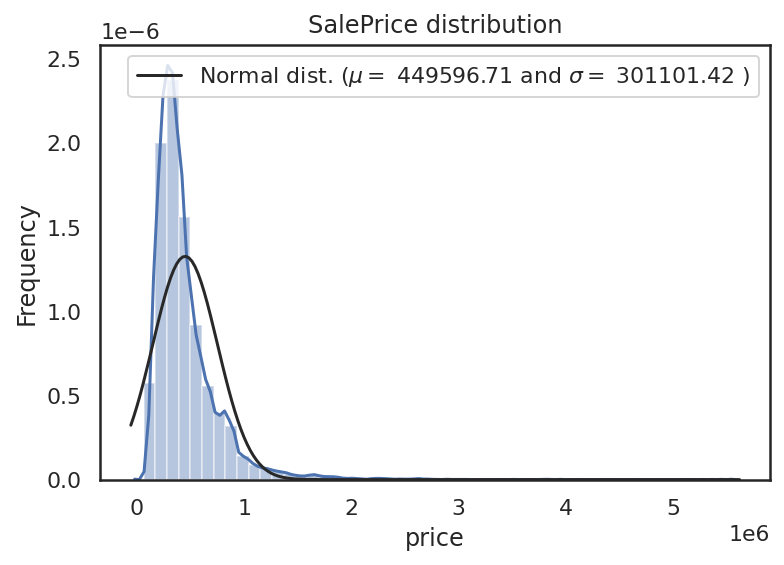

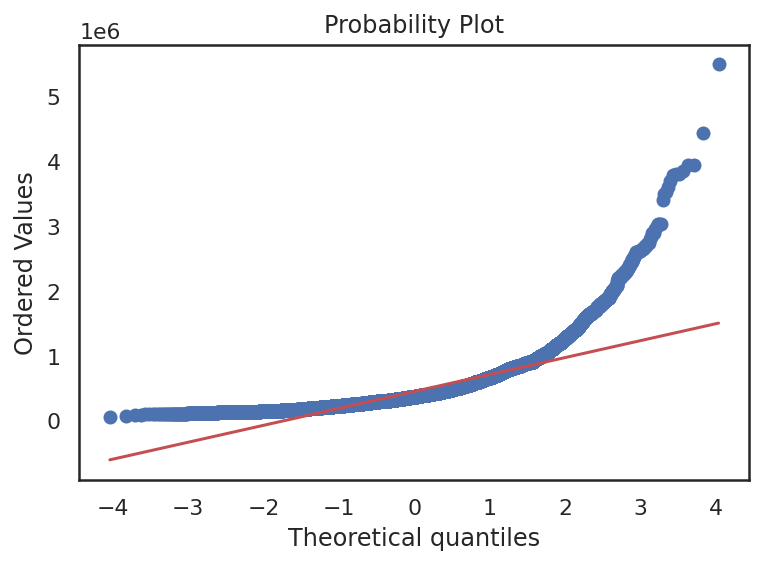

Skewness: 3.157941
Kurtosis: 19.488970


In [12]:
# Plot Histogram
sns.distplot(y_train, fit=norm)

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(y_train)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(y_train, plot=plt)
plt.show()

print("Skewness: %f" % y_train.skew())
print("Kurtosis: %f" % y_train.kurt())

* Comment: when we use the raw apartment prices, the APT prices seems not fit to normal distribution. We can find a same phenomenon in the quantile                 plot.


 mu = 12.86 and sigma = 0.54



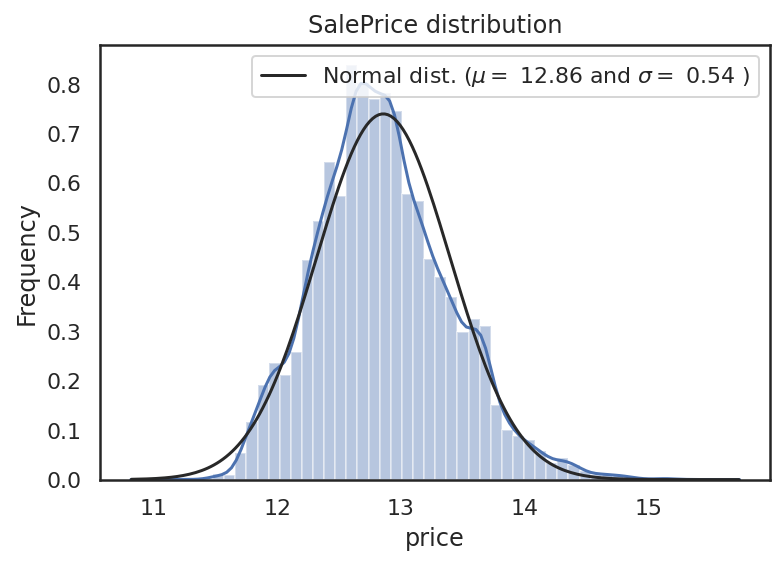

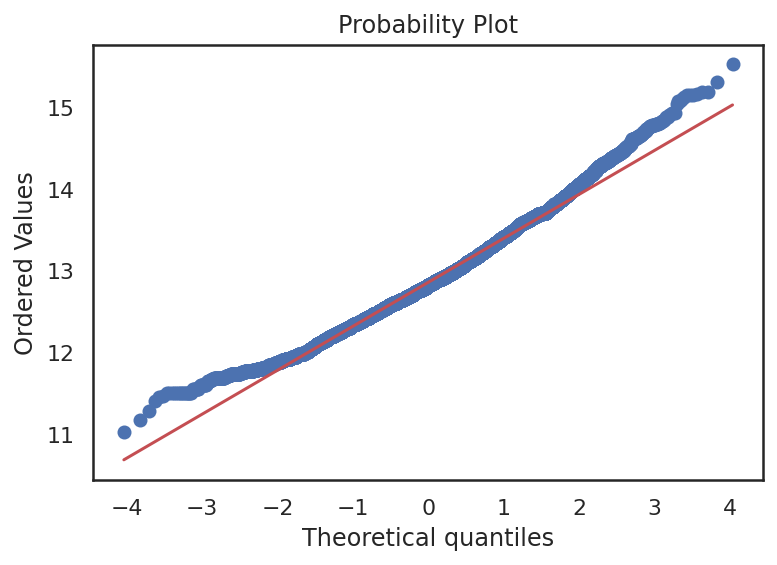

Skewness: 0.423978
Kurtosis: 0.275727


In [13]:
# We do a same analysis using log(price)
logy = np.log(y_train)

# Plot Histogram
sns.distplot(logy, fit=norm)

# Getting the fitted parameters used by the function
(mu, sigma) = norm.fit(logy)
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('SalePrice distribution')

fig = plt.figure()
res = stats.probplot(logy, plot=plt)
plt.show()

print("Skewness: %f" % logy.skew())
print("Kurtosis: %f" % logy.kurt())

* Comment: when we transform the APT prices in log(price), its distribution becomes closer to the normal distribution.

* In this analysis, we do not delve into the effect of the features we mentioned, and we just want to get the prediction and compare the prediction power of several models. 

* If we want to know the significance of the effects of the features on house prices, the assumption that prediction error should follow a normal distribution with mean 0 should be satisfied, since the calculation of confidence interval and variable significance is based on this assumption. 

* As mentioned before, since this is not a main interest of this analysis, we do not fix the non normality (skewness) of the target variable (price) for this analysis.

* If we do want to select the significant predicting factors, after constructiong a model and predicting, we should plot the chart to see the distribution of prediction error ([cf](https://towardsdatascience.com/is-normal-distribution-necessary-in-regression-how-to-track-and-fix-it-494105bc50dd)).

## * Average house prices by district.

* We look into a boxplot that represents the summary statistics (min, 1Q, Median, 3Q, max, outliers) of APT prices across districts.

(-0.5, 24.5, 0.0, 3000000.0)

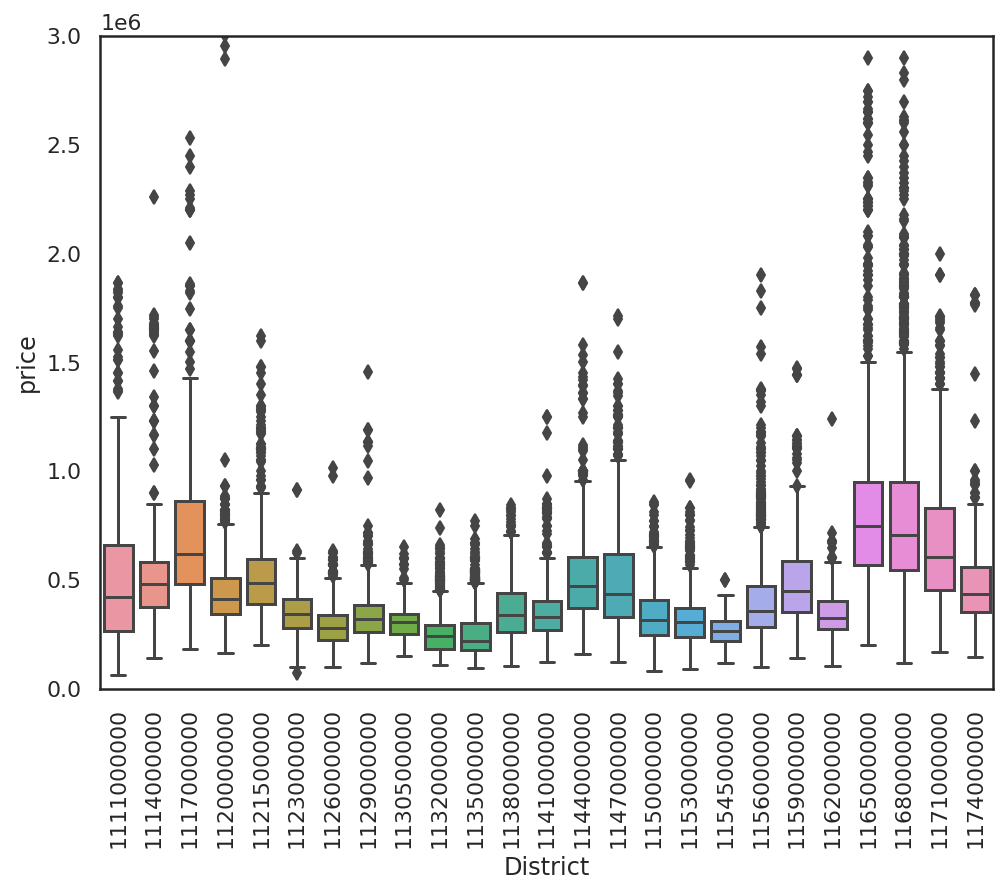

In [14]:
# APT house prices by district

var = 'District'
data = pd.concat([y_train, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="price", data=data)
fig.set_xticklabels(ax.get_xticklabels(),rotation=90)
fig.axis(ymin=0, ymax=3000000)


* Distributions of APT prices across districts are quite different. 

## * Average house prices by school district.


(-0.5, 10.5, 0.0, 3000000.0)

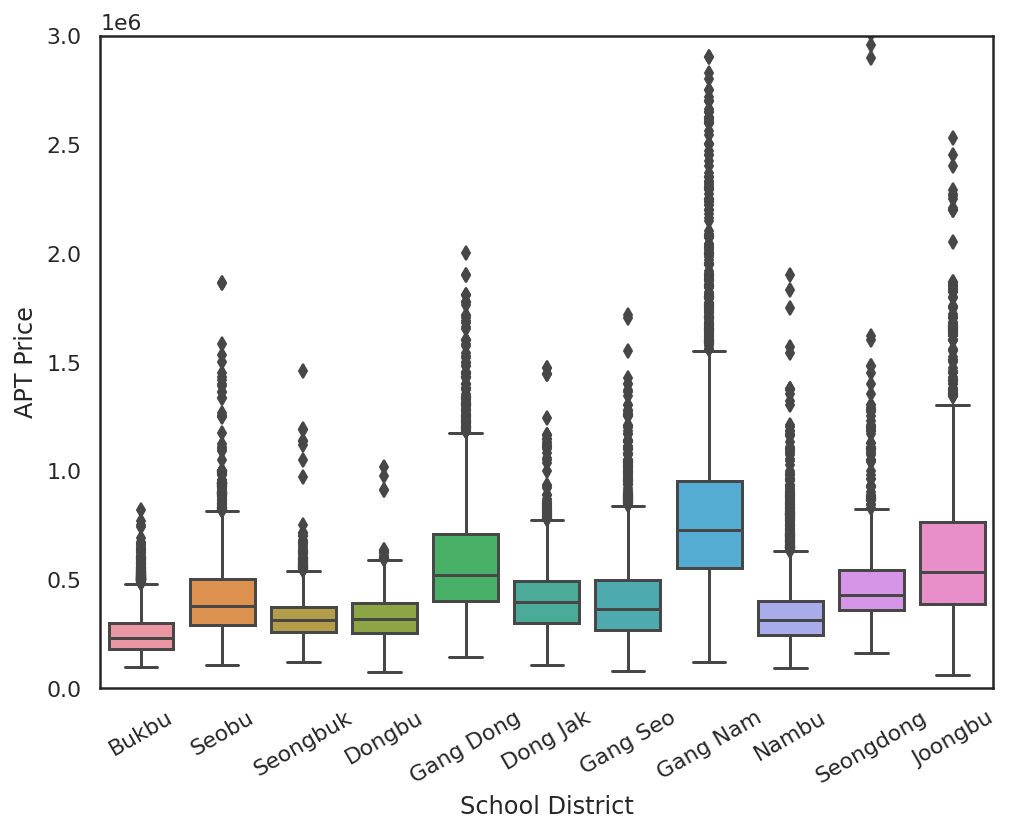

In [15]:
# APT house prices by school district

var = 'schoolDistHs'
data = pd.concat([y_train, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6));
fig = sns.boxplot(x=var, y="price", data=data)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.set_xlabel('School District')
fig.set_ylabel('APT Price')
fig.axis(ymin=0, ymax=3000000)


* We found that the APT prices across school districts are quite different.
* These variations in prices are due to the variations in the school quality.
> * school quality is measured as the percentage of students that are accepted to the best university (SNU) of the nearest 3 high schools from the APT.

(-0.5, 10.5, 0.0, 5.0)

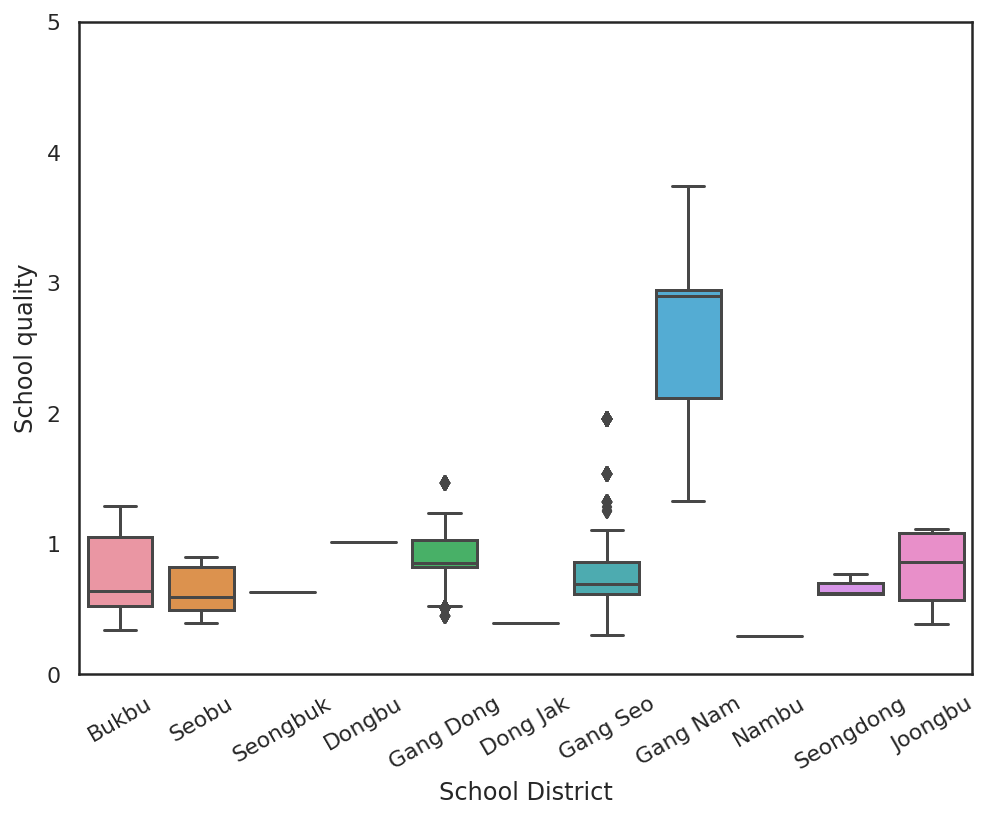

In [16]:
# School quality by school district

var = 'schoolDistHs'
xx = X_train['new..prop..snu23']
data = pd.concat([xx, X_train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6));
fig = sns.boxplot(x='schoolDistHs', y='new..prop..snu23', data=data)
fig.set_xticklabels(ax.get_xticklabels(),rotation=30)
fig.set_xlabel('School District')
fig.set_ylabel('School quality')
fig.axis(ymin=0, ymax=5)

## * Average house prices across the apt size, the floor, and the number of households.

* For the details on the seaborn graphs (jointplot), see [here](https://seaborn.pydata.org/generated/seaborn.jointplot.html)


Text(23.125, 0.5, 'Price')

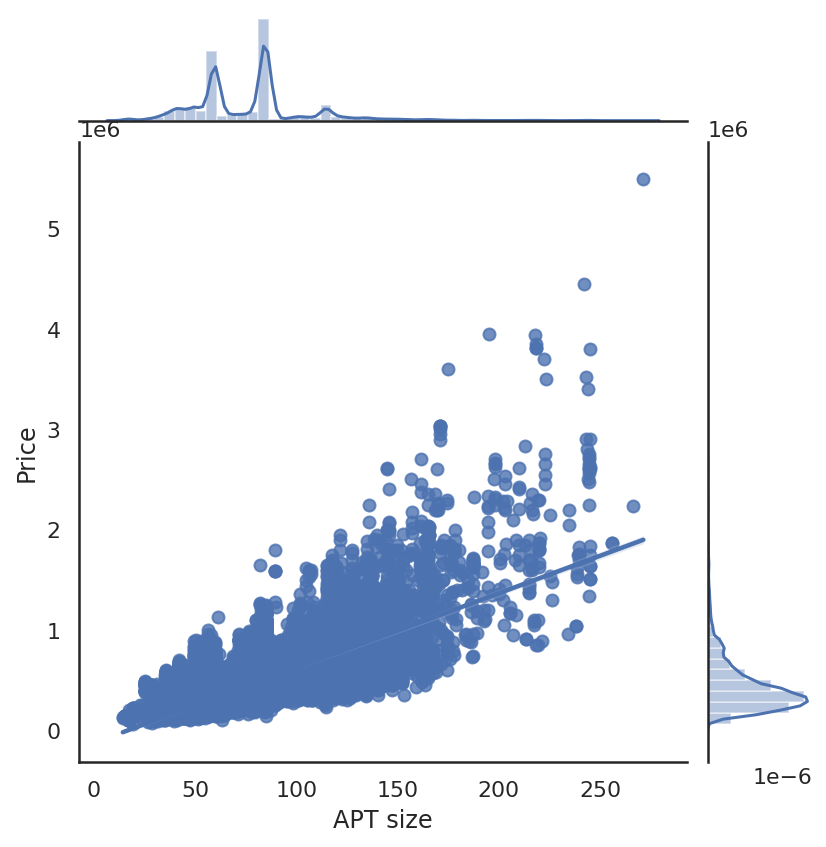

In [17]:
# Apt size vs Sale Price

fig= sns.jointplot(x=X_train['Size'], y= y_train, kind="reg" )
fig.ax_joint.set_xlabel('APT size')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

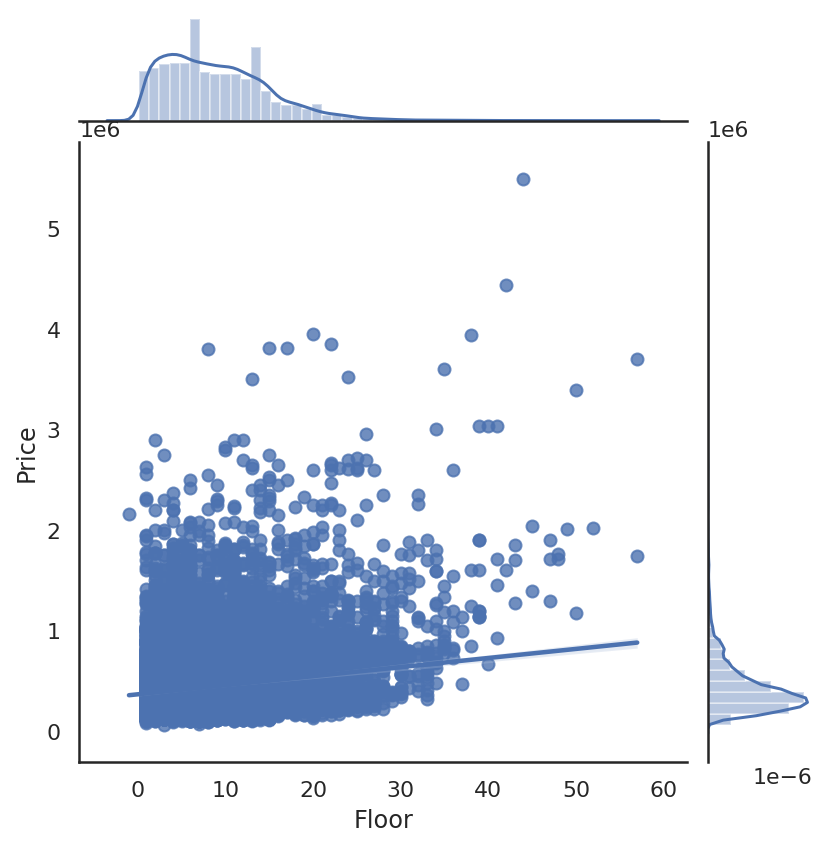

In [18]:
# Apt floor vs Sale Price


fig = sns.jointplot(x=X_train['Floor'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('Floor')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

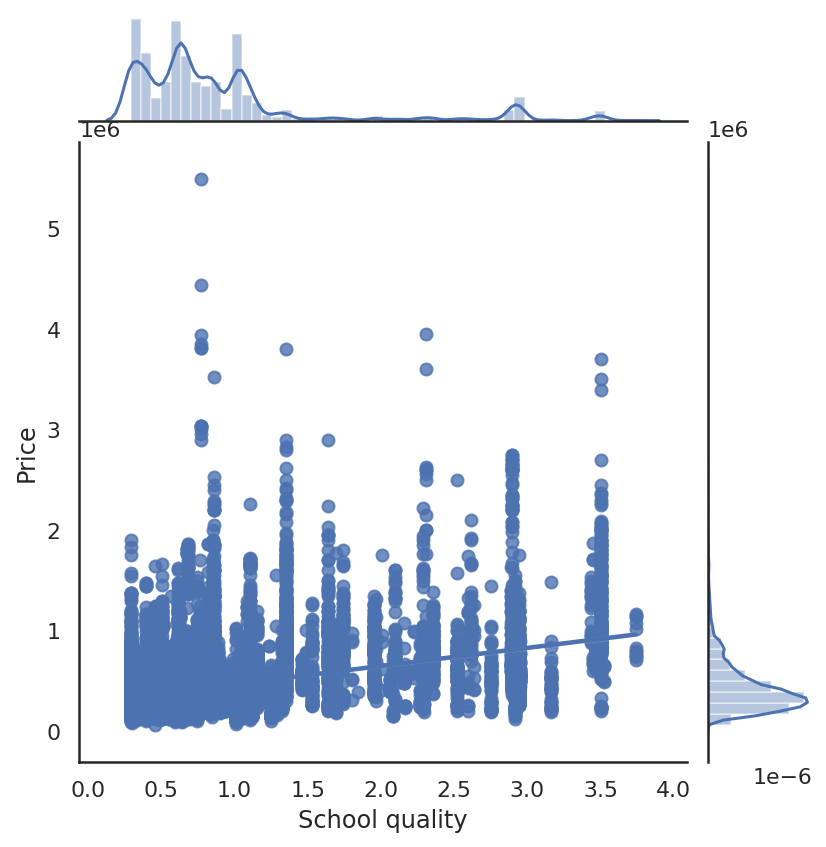

In [19]:
# School quality vs Sale Price

fig = sns.jointplot(x=X_train['new..prop..snu23'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('School quality')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

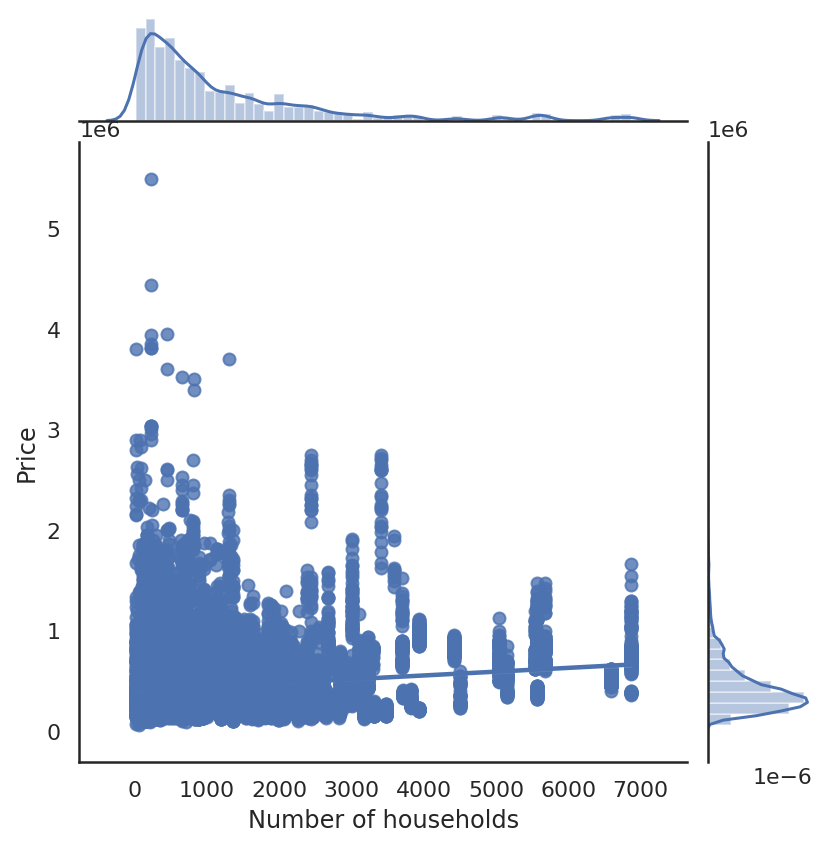

In [20]:
# Number of Households vs Sale Price

fig = sns.jointplot(x=X_train['Hhld'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('Number of households')
fig.ax_joint.set_ylabel('Price')

Text(23.125, 0.5, 'Price')

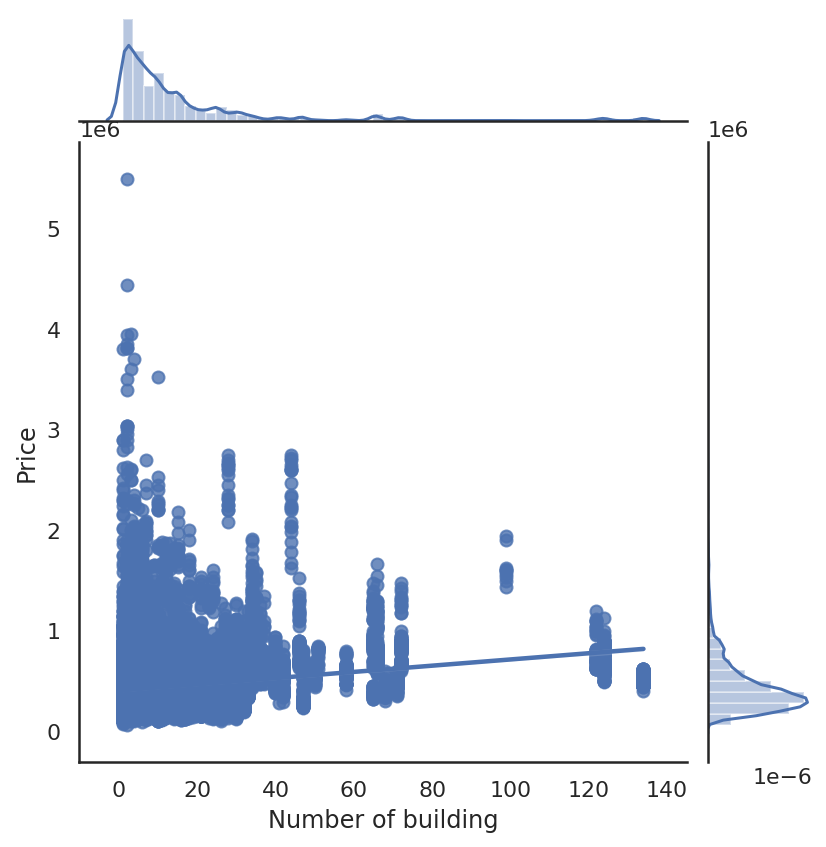

In [21]:
# No building vs Sale Price

fig = sns.jointplot(x=X_train['maxBuild'], y= y_train, kind='reg')
fig.ax_joint.set_xlabel('Number of building')
fig.ax_joint.set_ylabel('Price')

# Models and algorithms used

* For this analysis, we implement those algorithms:

> 1. Random Forests
> 2. XGBoost
> 3. Support vector regression
> 4. k-nearest neighbors
> 5. Multi-layer perceptron

* Note:

> * In order to find the best model, we use the metric of mean absolute errors (MAE). 
> * While using the function GridSearchCV() to find the optimal set of parameters for the algorithms, the Cross Validation score implemented and used is R^2.



## 1. Random Forests

* More details on the model can be found [here.](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html)
* Here, we also deal with overfitting problem. Different from the case of using Logisticregression classifier, here we select the value of max_leaf_nodes that gives the most accurate model on your data.
> * Actually, we can also use other parameters such as "n_estimators", "max_features", and "max_depth".
> * The effect of "max_depth" on over-fitting probabilities is similar to the one of "min_samples_leaf".
> * From the analysis with different combination of parameters, we found that the set of parameters leading to the minimum value of MAE of 'n_estimators', 'min_samples_leaf', and 'max_features' are about '400', '1', and '20', respectively.
* For more details on regularization problem in the RandomForest classifier, see [here](https://www.quora.com/How-could-I-regularize-random-forest-classifiers) or [this](https://stackoverflow.com/questions/20463281/how-do-i-solve-overfitting-in-random-forest-of-python-sklearn) and [that.](https://www.analyticsvidhya.com/blog/2015/06/tuning-random-forest-model/)

In [22]:
# Define a fct to get the mean absolute error values for each 'min_samples_leaf' values

def get_mae(msl, train_X, val_X, train_y, val_y):
    
    # Define the model. Set random_state to 1
    rf_model = RandomForestRegressor(n_estimators=400, random_state=1, criterion = "mse", min_samples_leaf=msl, max_features=20)

    # Fit your model
    rf_model.fit(train_X, train_y)
    
    # predict
    pred = rf_model.predict(val_X)
    
    # Calculate the mean absolute error of your Random Forest model on the validation data
    rf_val_mae = mean_absolute_error(val_y, pred)

    print("Validation MAE for Random Forest Model: {}".format(rf_val_mae))
   
    return(rf_val_mae)

# Repeated training with different set of parameters 'min_samples_leaf'

candidate_min_samples_leaf = [1,2,3,5,10,20,40,80]

# Write a loop function to find the ideal tree size from candidate_max_leaf_nodes

set_mae=[] 

for msl in candidate_min_samples_leaf:
    set_mae.append(get_mae(msl, OH_X_train, OH_X_valid, y_train, y_valid))
    

# Store the best value of min_samples_leaf 
best_leaf_size = candidate_min_samples_leaf[set_mae.index(min(set_mae))]    

print("Value of MAE for the optimal Random Forest Model is as follows:")

get_mae(best_leaf_size, OH_X_train, OH_X_valid, y_train, y_valid)


print("Value of MAE for the optimal Random Forest Model is as follows (test data):")

get_mae(best_leaf_size, OH_X_train, OH_X_test, y_train, y_test)


Validation MAE for Random Forest Model: 27822.973052815687
Validation MAE for Random Forest Model: 28099.491308370045
Validation MAE for Random Forest Model: 28935.956484663857
Validation MAE for Random Forest Model: 30794.50048689008
Validation MAE for Random Forest Model: 35164.16436659453
Validation MAE for Random Forest Model: 41095.56240531134
Validation MAE for Random Forest Model: 48347.58518185425
Validation MAE for Random Forest Model: 57293.72962762956
Value of MAE for the optimal Random Forest Model is as follows:
Validation MAE for Random Forest Model: 27822.973052815687
Value of MAE for the optimal Random Forest Model is as follows (test data):
Validation MAE for Random Forest Model: 57792.74974536979


57792.74974536979

In [23]:
print("The best parameter for 'min_samples_leaf' is:", best_leaf_size)

The best parameter for 'min_samples_leaf' is: 1


## 2. XGBoost

* XGBoost stands for Extreme Gradient Boosting and it is an implementation of gradient boosting trees algorithm.
* More details on this algorithm can be found [here.](https://www.kaggle.com/mldaniella/exercise-xgboost) and [there](https://xgboost.readthedocs.io/en/latest/tutorials/model.html)
* [the evolution of tree based algorithm from decision tree to XGboost](https://towardsdatascience.com/https-medium-com-vishalmorde-xgboost-algorithm-long-she-may-rein-edd9f99be63d)

## 2.1 Parameter tuning problem

* More details on parameter tuning can be found [here.](https://www.kaggle.com/alexisbcook/xgboost)

* XGBoost has a few parameters that can dramatically affect accuracy and training speed. 

> * **n_estimators**: n_estimators indicates the number of models that we include in the ensemble.
> > * Too low value causes underfitting, and too high value causes overfitting.

> * **early_stopping_rounds**: early_stopping_rounds indicates the minimum round where the model would stop if the validation score stops improving. It's better to set a high value for 'n_estimators' and then use early_stopping_rounds to find the optimal time to stop iterating.
For instance, setting early_stopping_rounds=5 means that we stop after 5 straight rounds of deteriorating validation scores.

> * **learning_rate**: 
Instead of getting predictions by simply adding up the predictions from each component model, we can multiply the predictions from each model by a small number (known as the learning rate) before adding them in. As default, XGBoost sets learning_rate=0.1.

> * **n_jobs**:
On larger datasets where runtime is a consideration, you can use parallelism to build your models faster. It's common to set the parameter n_jobs equal to the number of cores on your machine. On smaller datasets, this won't help.




In [24]:

# Define a fct to get mae values. We use this fct to find an optimal set of parameters in using the XGboost algorithm

def get_mae_xgb(mymodel, earlyval=None, learning_rate=None, xdat = OH_X_valid, ydat= y_valid):
    
    my_model=mymodel
    
    if earlyval is not None:
        my_model.fit(OH_X_train, y_train, 
                     early_stopping_rounds=earlyval, 
                     eval_set=[(OH_X_valid, y_valid)],
                     verbose=False)  
    else:    
        my_model.fit(OH_X_train, y_train)
    
    predictions = my_model.predict(xdat)
    
    mae= mean_absolute_error(predictions,ydat)
    
    if earlyval is not None:
        print('===ealry stopping rounds vary===')
        print("Mean Absolute Error: " + str(mae))
    
    elif learning_rate is not None:
        print('===learning rates vary===')
        print("Mean Absolute Error: " + str(mae))
    
    else:
        print("Mean Absolute Error: " + str(mae))

    return mae


* Using the default value of parameters, we calculated Mean absolute error values

In [25]:
# Only with 'default parameter' values

my_model = XGBRegressor(random_state=0)


print("Value of MAE for the optimal Random Forest Model is as follows:")
get_mae_xgb(my_model)

print("Value of MAE for the optimal Random Forest Model is as follows (test data):")
get_mae_xgb(my_model,earlyval=None, learning_rate=None, xdat= OH_X_test, ydat= y_test)


Value of MAE for the optimal Random Forest Model is as follows:
Mean Absolute Error: 32658.562774558766
Value of MAE for the optimal Random Forest Model is as follows (test data):
Mean Absolute Error: 63108.123633920135


63108.123633920135

* Now we want to vary the value of n_estimators.

In [26]:
# Varying 'n_estimators' values

nestim=[300,400,500,1000,1500,2000]

set_mae=[]

for nn in nestim:
    
    my_model1 = XGBRegressor(random_state=0, n_estimators=nn)
    set_mae.append(get_mae_xgb(my_model1))

    

# Mean absolute error values with the best parameter

best_nestime_size = nestim[set_mae.index(min(set_mae))]    
my_best_model1 = XGBRegressor(random_state=0, n_estimators=best_nestime_size)

print("Value of MAE for the optimal Random Forest Model is as follows:")
get_mae_xgb(my_best_model1)


print("Value of MAE for the optimal Random Forest Model is as follows (test data):")
get_mae_xgb(my_best_model1, xdat= OH_X_test, ydat= y_test)

Mean Absolute Error: 27901.43205973623
Mean Absolute Error: 27391.04380091156
Mean Absolute Error: 27148.95487781226
Mean Absolute Error: 27355.662112102404
Mean Absolute Error: 27672.951044899146
Mean Absolute Error: 27978.37583640419
Value of MAE for the optimal Random Forest Model is as follows:
Mean Absolute Error: 27148.95487781226
Value of MAE for the optimal Random Forest Model is as follows (test data):
Mean Absolute Error: 61457.391581255906


61457.391581255906

In [27]:
print("The best parameter for 'n_estimator' is:", best_nestime_size)


The best parameter for 'n_estimator' is: 500


* Now we want to vary the value of 'early stopping rounds', keeping the value of n_estimator fixed (best_nestime_size)

In [28]:
# Varying 'early stopping rounds' values


vall=[5,10,15,20,25,30,40,50,100] # candidates of early stop rounds

set_mae=[]

for val in vall:
    my_model2 = XGBRegressor(random_state=0, n_estimators=best_nestime_size)
    set_mae.append(get_mae_xgb(my_model2, earlyval=val))

# Mean absolute error values with the best parameter

best_est = vall[set_mae.index(min(set_mae))]    

print("Value of MAE for the optimal Random Forest Model is as follows:")
get_mae_xgb(my_model2, earlyval=best_est)


print("Value of MAE for the optimal Random Forest Model is as follows (test data):")
get_mae_xgb(my_model2, earlyval=best_est, xdat= OH_X_test, ydat= y_test)

===ealry stopping rounds vary===
Mean Absolute Error: 29883.65771431342
===ealry stopping rounds vary===
Mean Absolute Error: 27863.18114211598
===ealry stopping rounds vary===
Mean Absolute Error: 27863.18114211598
===ealry stopping rounds vary===
Mean Absolute Error: 27863.18114211598
===ealry stopping rounds vary===
Mean Absolute Error: 27863.18114211598
===ealry stopping rounds vary===
Mean Absolute Error: 27243.71249272692
===ealry stopping rounds vary===
Mean Absolute Error: 27243.71249272692
===ealry stopping rounds vary===
Mean Absolute Error: 27243.71249272692
===ealry stopping rounds vary===
Mean Absolute Error: 27243.71249272692
Value of MAE for the optimal Random Forest Model is as follows:
===ealry stopping rounds vary===
Mean Absolute Error: 27243.71249272692
Value of MAE for the optimal Random Forest Model is as follows (test data):
===ealry stopping rounds vary===
Mean Absolute Error: 61608.821877953684


61608.821877953684

In [29]:
print("The best parameter for 'early stopping rounds' is:", best_est)


The best parameter for 'early stopping rounds' is: 30


* Now we want to vary the value of 'learning rate', keeping the values of 'n_estimator' and 'early stopping rounds' constant.

In [30]:
# Varying 'learning rate' values

LRval=[0.01,0.02,0.04, 0.05, 0.1, 0.2,0.4, 0.5]
val=best_est

set_mae=[]

for LRvall in LRval:
    my_model3 = XGBRegressor(random_state=0,n_estimators= best_nestime_size, learning_rate=LRvall)
    set_mae.append(get_mae_xgb(my_model3, earlyval=val, learning_rate = LRvall))
    
# Mean absolute error values with the best parameter

best_lr = LRval[set_mae.index(min(set_mae))]    

print("Value of MAE for the optimal Random Forest Model is as follows:")
get_mae_xgb(my_model3, earlyval=val, learning_rate=best_lr)


print("Value of MAE for the optimal Random Forest Model is as follows (test data):")
get_mae_xgb(my_model3, earlyval=val, learning_rate=best_lr, xdat= OH_X_test, ydat= y_test)

===ealry stopping rounds vary===
Mean Absolute Error: 43116.46312063615
===ealry stopping rounds vary===
Mean Absolute Error: 38530.87309324089
===ealry stopping rounds vary===
Mean Absolute Error: 33904.557994327
===ealry stopping rounds vary===
Mean Absolute Error: 32621.811108417376
===ealry stopping rounds vary===
Mean Absolute Error: 29081.362066039565
===ealry stopping rounds vary===
Mean Absolute Error: 27510.50390321955
===ealry stopping rounds vary===
Mean Absolute Error: 28066.67588246703
===ealry stopping rounds vary===
Mean Absolute Error: 28935.597016825057
Value of MAE for the optimal Random Forest Model is as follows:
===ealry stopping rounds vary===
Mean Absolute Error: 28935.597016825057
Value of MAE for the optimal Random Forest Model is as follows (test data):
===ealry stopping rounds vary===
Mean Absolute Error: 64755.916693126775


64755.916693126775

In [31]:
print("The best parameter for 'learning rate' is:", best_lr)


The best parameter for 'learning rate' is: 0.2


## 2.2 Optimizing parameters using Cross Validation and GridSearchCV()

* Until now, we tried to find the optimal set of hyperparameters of XGboost in a rather manual way, and we found that there is a limit to find the best combination of the parameters in this way (keeping the optimal parameters in a row does not lead us to a lower MAE).
* However, here we use a more elaborate method 'GridSearchCV()' to get the optimal set of hyperparameters since XGboost has a lot of hyperparameters that we have to manually configure, including max_depth (maximum tree depth), learning_rate (the learning rate), gamma (a parameter that encourages pruning), and reg_lambda (the regularization parameter).

In [32]:
# Using GridSearchCV() to find the best combination of parameters

## First trial

# param_grid= {
#     'max_depth': [3,4,5],
#     'learning_rate': [0.1,0.01,0.05],
#     'gamma': [0,0.25,1],
#     'n_estimators': [500, 600, 700],   
# }

## 1st trial
#{'early_stopping_rounds': 30, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 700}


## Second trial 
# param_grid= {
#     'max_depth': [5,6,7],
#     'learning_rate': [0.1,0.2,0.3],
#     'gamma': [0,0.05,0.01],
#     'n_estimators': [700,800,900],
# }



## 2nd trial
#{'early_stopping_rounds': 30, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 900}

## Third trial 
# param_grid= {
#     'max_depth': [6],
#     'learning_rate': [0.1],
#     'gamma': [0],
#     'n_estimators': [1100,1500,2000,2500],
# }

## 3rd trial
#{'early_stopping_rounds': 30, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1500} # best combination of parameters!!


## Best parameters obatined through GridSearchCV()

best_est = 30

param_grid = {
            'max_depth': [6],
            'learning_rate': [0.1],
            'gamma': [0],
            'n_estimators': [1500]
}

    
XGB=XGBRegressor(random_state=0, 
                         colsample_bytree=0.5)

XGB_grids = GridSearchCV(estimator = XGB,
                         param_grid=param_grid,
                         verbose=0,
                         cv=5)


# fitting the model for grid search 

XGB_grids.fit(OH_X_train, y_train,
              early_stopping_rounds = best_est,
              eval_set=[(OH_X_valid, y_valid)], 
             verbose=False)


# Results with the best parameters
print('The best model is: ', XGB_grids.best_params_)
print('This model produces a mean cross-validated score (precision) of', XGB_grids.best_score_)

# getting the mean absolute error using the test dataset and the best parameters
y_true, y_pred = y_valid, XGB_grids.predict(OH_X_valid)

print('MAE on the evaluation set: ',mean_absolute_error(y_true, y_pred))


# getting the mean absolute error using the test dataset and the best parameters
y_true, y_pred = y_test, XGB_grids.predict(OH_X_test)

print('MAE on the evaluation set: ',mean_absolute_error(y_true, y_pred))


The best model is:  {'gamma': 0, 'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 1500}
This model produces a mean cross-validated score (precision) of 0.966785825929185
MAE on the evaluation set:  27627.749641194725
MAE on the evaluation set:  61655.09750302753


## 3. Support vector machine 

* For more details on the Support vector machine, see this [video.](https://www.youtube.com/watch?v=efR1C6CvhmE&t=21s)
* [Other materials on SVM (SVC)](https://www.kaggle.com/fengdanye/machine-learning-4-support-vector-machine)
* [Materials on SVR](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVR.html)

* Using, GridSearchCV(), we tried to find the best combinations of parameters (especially, 'C' (Regularization parameter))

In [33]:
# Modeling and finding the set of parameters optimal for the algorithm

modelsvr = SVR()

# first trial 
# param = {'kernel' : ['rbf'],
#          'C' : [1,3,5,7,9,11,13,15],
#          'gamma' : ['auto']}

# the best set of parameters

param = {'kernel' : ['rbf'],
         'C' : [9],
         'gamma' : ['auto']}

svr_grids = GridSearchCV(estimator= modelsvr,
                         param_grid= param,
                         cv=5)

svr_grids.fit(OH_X_train, y_train)



# Results with the best parameters

print(svr_grids.cv_results_)
print('The best model is: ', svr_grids.best_params_)
print('This model produces a mean cross-validated score (precision) of', svr_grids.best_score_)


# getting the mean absolute error using the test dataset and the best parameters

y_true, y_pred = y_test, svr_grids.predict(OH_X_test)
print('MAE on the evaluation set: ',mean_absolute_error(y_true, y_pred))



{'mean_fit_time': array([32.19264374]), 'std_fit_time': array([0.08392591]), 'mean_score_time': array([3.94616513]), 'std_score_time': array([0.01769891]), 'param_C': masked_array(data=[9],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_gamma': masked_array(data=['auto'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_kernel': masked_array(data=['rbf'],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}], 'split0_test_score': array([-0.08776595]), 'split1_test_score': array([-0.07707364]), 'split2_test_score': array([-0.09086817]), 'split3_test_score': array([-0.08253835]), 'split4_test_score': array([-0.07650481]), 'mean_test_score': array([-0.08295018]), 'std_test_score': array([0.00569443]), 'rank_test_score': array([1], dtype=int32)}
The best model is:  {'C': 9, 'gamma': 'auto', 'kernel': 'rbf'}
This model produces a mean cross-va

## 4. k-nearest neighbors algorithm (KNN algorithm)

* For more details on the k-nearest neighbors algorithm, see this [video.](https://www.youtube.com/watch?v=HVXime0nQeI)
> * We cluster the observations by [PCA](https://www.youtube.com/watch?v=FgakZw6K1QQ) first then apply the k nearest neighbors algorithm?[](http://)

49085.48440453686

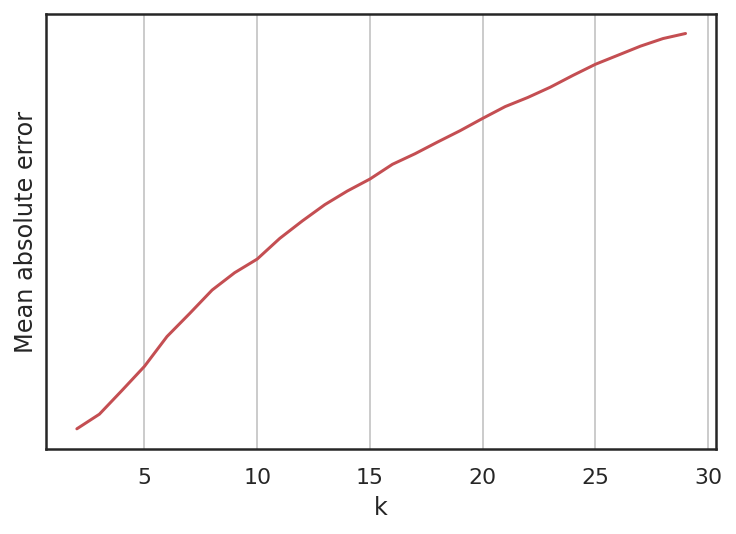

In [34]:

# Modeling and finding the set of parameters optimal for the algorithm

def sklearn_reg(train_data, label_data, test_data, k_num):
    knn = neighbors.KNeighborsRegressor(n_neighbors=k_num, weights='uniform', algorithm='auto')
    # Train
    knn.fit(train_data, label_data)
    # Predict
    predict_label = knn.predict(test_data)
    # Return
    return predict_label
                               
                               
# Predict using the training data set, assuming k = 5 

y_predict = sklearn_reg(OH_X_train, y_train, OH_X_valid, 5)
y_predict
                               

# mean absolute error calculation

def get_mae_knear(predictions, y_valid):  
    mae = mean_absolute_error(predictions, y_valid)
    return mae
    
                               
get_mae_knear(y_predict, y_valid)


# Search for the value 'k' that leads to the minimum absolute error values
                               
normal_mae = []  # Create an empty list of accuracy rates
k_value = range(2, 30)


for k in k_value:
    y_predict = sklearn_reg(OH_X_train, y_train, OH_X_valid, k)
    mae = get_mae_knear(y_valid, y_predict)
    normal_mae.append(mae)

# draw a graph of accuracy level across 'k'

plt.xlabel("k")
plt.ylabel("Mean absolute error")
new_ticks = np.linspace(0.6, 0.9, 30)  # Set the y-axis display
plt.yticks(new_ticks)
plt.plot(k_value, normal_mae, c='r')
plt.grid(True)  # Add grid
      

# calculate mae usig test data and best parameter 'k'
best_k=k_value[normal_mae.index(min(normal_mae))]
get_mae_knear(sklearn_reg(OH_X_train, y_train, OH_X_valid,best_k), y_valid)
get_mae_knear(sklearn_reg(OH_X_train, y_train, OH_X_test,best_k), y_test)


## 5. Multi-layer perceptron

* More details on the model can be found [here](https://www.kaggle.com/victorcoo/learn01-titanic-with-mlpclassifier-mlpregressor) and [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPRegressor.html)

In [35]:
# Modeling and finding the set of parameters optimal for the algorithm

MLP = MLPClassifier(random_state=0)

# First trial
# param_list = {"hidden_layer_sizes": [(100,),(300,),(500,)], 
#               "activation": ["logistic", "relu"], 
#               "solver": ["lbfgs", "adam"], 
#               "alpha": [0.001,0.005], # L2 penalty (regularization term) parameter
#               "batch_size": [100,200]
#              }

# Second trial
# param_list = {"hidden_layer_sizes": [(100,),(50,50), (50,25,25)], 
#               "activation": ["logistic", "relu"], 
#               "solver": ["lbfgs", "adam"], 
#               "alpha": [0.001], # L2 penalty (regularization term) parameter
#               "batch_size": [100]
#              }

# Third trial

# param_list = {"hidden_layer_sizes": [(100,)], 
#               "activation": ["logistic", "relu"], 
#               "solver": ["lbfgs", "adam"], 
#               "alpha": [0.001,0.005], # L2 penalty (regularization term) parameter
#               "batch_size": [100,200]
#              }

# Final model (w the set of best parameters)

param_list = {"hidden_layer_sizes": [(100,)], 
              "activation": ["logistic"], 
              "solver": ["lbfgs"], 
              "alpha": [0.001], # L2 penalty (regularization term) parameter
              "batch_size": [100]
             }


MLP_grids = GridSearchCV(estimator= MLP,
                     param_grid= param_list,
                     cv=5)

MLP_grids.fit(OH_X_train, y_train)

# Results with the best parameters
print(MLP_grids.cv_results_)            
print('The best model is: ', MLP_grids.best_params_)
print('This model produces a mean cross-validated score (precision) of', MLP_grids.best_score_)


# getting the mean absolute error using the test dataset and the best parameters
y_true, y_pred = y_test, MLP_grids.predict(OH_X_test)
print('MAE on the evaluation set: ',mean_absolute_error(y_true, y_pred))

{'mean_fit_time': array([71.13655586]), 'std_fit_time': array([4.16212308]), 'mean_score_time': array([0.31346464]), 'std_score_time': array([0.00218729]), 'param_activation': masked_array(data=['logistic'],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_alpha': masked_array(data=[0.001],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_batch_size': masked_array(data=[100],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_hidden_layer_sizes': masked_array(data=[(100,)],
             mask=[False],
       fill_value='?',
            dtype=object), 'param_solver': masked_array(data=['lbfgs'],
             mask=[False],
       fill_value='?',
            dtype=object), 'params': [{'activation': 'logistic', 'alpha': 0.001, 'batch_size': 100, 'hidden_layer_sizes': (100,), 'solver': 'lbfgs'}], 'split0_test_score': array([0.01377036]), 'split1_test_score': array([0.01377036]), 'split2_tes

# Conclusion

* The summary of MAE values obtained from the differnet algorithm is as follows.
* With validation data
* With test data



In [36]:
### Summmary of MAE values from different algorithms 

## Random Forest model 

print("Value of MAE for the Random Forest Model on the evaluation set is as follows (validation data):")
get_mae(best_leaf_size, OH_X_train, OH_X_valid, y_train, y_valid)

print("Value of MAE for the Random Forest Model on the evaluation set is as follows (test data):")
get_mae(best_leaf_size, OH_X_train, OH_X_test, y_train, y_test)


## XGBoost algorithm + Random forest model

y_true, y_pred = y_valid, XGB_grids.predict(OH_X_valid)
print('Value of MAE for the XGB on the evaluation set is as follows (validation data): ',mean_absolute_error(y_true, y_pred))

y_true, y_pred = y_test, XGB_grids.predict(OH_X_test)
print('Value of MAE for the XGB on the evaluation set is as follows (test data): ',mean_absolute_error(y_true, y_pred))


## support vector regressor
y_true, y_pred = y_valid, svr_grids.predict(OH_X_valid)
print('Value of MAE for the Support Vector regressor on the evaluation set (validation data): ',mean_absolute_error(y_true, y_pred))

y_true, y_pred = y_test, svr_grids.predict(OH_X_test)
print('Value of MAE for the Support Vector regressor on the evaluation set (test data): ',mean_absolute_error(y_true, y_pred))


##  k nearest algorithm 
best_k=k_value[normal_mae.index(min(normal_mae))]
print('Value of MAE for the k neareast algorithm on the evaluation set (validation data): ',get_mae_knear(sklearn_reg(OH_X_train, y_train, OH_X_valid,best_k), y_valid))
print('Value of MAE for the k neareast algorithm on the evaluation set (test data): ',get_mae_knear(sklearn_reg(OH_X_train, y_train, OH_X_test,best_k), y_test))


##  Multi layer perceptron
y_true, y_pred = y_valid, MLP_grids.predict(OH_X_valid)
print('Value of MAE for the Multi layer perceptron on the evaluation set (validation data): ',mean_absolute_error(y_true, y_pred))
y_true, y_pred = y_test, MLP_grids.predict(OH_X_test)
print('Value of MAE on  the Multi layer perceptron on the evaluation set (test data): ',mean_absolute_error(y_true, y_pred))



Value of MAE for the Random Forest Model on the evaluation set is as follows (validation data):
Validation MAE for Random Forest Model: 27822.973052815687
Value of MAE for the Random Forest Model on the evaluation set is as follows (test data):
Validation MAE for Random Forest Model: 57792.74974536979
Value of MAE for the XGB on the evaluation set is as follows (validation data):  27627.749641194725
Value of MAE for the XGB on the evaluation set is as follows (test data):  61655.09750302753
Value of MAE for the Support Vector regressor on the evaluation set (validation data):  186138.04170836727
Value of MAE for the Support Vector regressor on the evaluation set (test data):  186002.24945948724
Value of MAE for the k neareast algorithm on the evaluation set (validation data):  33276.017067494184
Value of MAE for the k neareast algorithm on the evaluation set (test data):  49085.48440453686
Value of MAE for the Multi layer perceptron on the evaluation set (validation data):  196864.0775

* Conclusion: we found that the `k nearest algorithm` gives the best prediction result.

# Pipeline (Random Forest Model)

* We construct a pipeline for predicting the ATP prices in Seoul. For this analysis, we do not add additional features tha cannot be implemented using the preprocessing functions.

* For more details on Pipelines and its advantages, see [this note.](https://www.kaggle.com/dansbecker/pipelines)


In [37]:
# Preprocessing for numerical data
numerical_transformer = SimpleImputer(strategy='mean')

# Preprocessing for categorical data using "Pipeline"
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

# Bundle preprocessing for numerical and categorical data using "ColumnTransformer"
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])



# Define model (optmal model + optimal parameter)
model = RandomForestRegressor(n_estimators=100, random_state=0)


# Bundle preprocessing and modeling code in a pipeline
my_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                      ('model', model)
                     ])


# Preprocessing of training data, fit model 
my_pipeline.fit(X_train, y_train)


# Preprocessing of validation data, get predictions
preds = my_pipeline.predict(X_valid)

print('MAE:', mean_absolute_error(y_valid, preds))


# Preprocessing of test data, fit model
preds_test = my_pipeline.predict(X_test)


# Save test predictions to file
output = pd.DataFrame({'Id': X_test.index,
                       'SalePrice': preds_test})
output.to_csv('submission.csv', index=False)



MAE: 27464.068589558156
